## Semantic Data Filter

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

EMBEDDED_CATEGORIES_FILE = 'data/embedded_categories.npy'

embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [11]:
df_business = pd.read_csv('data/yelp_academic_dataset_business.csv')
df_business = df_business.dropna(subset=['categories'])

`data/yelp_academic_dataset_business.csv` stores the business type in the column `categories`.

Two immediate methods to filter the data:
- Manually search the desired labels in the set, `all_labels` for all businesses matching the desired labels.  Filter to obtain the subset.
- Apply a text embedder to calculate the similarity between a query string and the category description.

This notebook walks through the steps for the latter option, but also provides a set of all the labels that occur in the `categories` column of the `DataFrame`

In [12]:
df_business.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",NaN
4,4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': ""{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


### Method 1 Labels:

In [13]:
all_labels_list = [label for category in df_business['categories'] for label in category.split(", ")]
all_labels = set(all_labels_list)
print("TOTAL NUMBER OF LABELS: ", len(all_labels))

TOTAL NUMBER OF LABELS:  1330


### Method 2 Embeddings:
[Google's Universal Sentence Encoder (USE)](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder)

In short, USE converts text to vectors:
- query: `Food...` $\to \vec{q}$
- Business $j$, category $j$: `Gastropubs, Food, Beer Gardens, Restaurants, B...` $\to \vec{c_j}$
- Business $k$, category $k$: `Antiques, Fashion, Used, Vintage & Consignment...` $\to \vec{c_k}$

We observe:

$$\textrm{Similarity Score}_j = \vec{q} \cdot \vec{c_j} > \vec{q}\cdot\vec{c_k} = \textrm{Similarity Score}_k$$

due to the semantic similarity to `Food`

In [14]:
try:
    with open(EMBEDDED_CATEGORIES_FILE, 'rb') as f:
        embedded_categories = np.load(EMBEDDED_CATEGORIES_FILE, allow_pickle=True)
    print('EMBEDDINGS LOADED')

except IOError as e:
    print('ARRAY NOT FOUND. EMBEDDING:')
    categories = list(df_business['categories'])
    embedded_categories = embedder(categories).numpy()
    np.save(EMBEDDED_CATEGORIES_FILE, embedded_categories)
    print('EMBEDDINGS SAVED')

EMBEDDINGS LOADED


Change `query` to include desired comparison text

In [15]:
restaurants = set(pd.read_csv('data/Top250.csv')['Segment_Category'])
restaurants_keywords = restaurant_text = " ".join(restaurants)
query = restaurants_keywords
#query = 'burger'

QUERY TO MATCH:
Casual Dining & Seafood Italian/Pizza Casual Dining & Asian Fast Casual & Sandwich Steak Asian Casual Dining & Steak Seafood Quick Service & Frozen Desserts Quick Service & Beverage Chicken Bakery Cafe Mexican Fast Casual & Pizza Ethnic Fast Casual & Bakery Cafe Casual Dining & Varied Menu Quick Service & Snack Quick Service & Sandwich Quick Service & Pizza Fast Casual & Chicken Frozen Desserts Casual Dining & Italian/Pizza Sports Bar Healthy Quick Service & Bakery Cafe BBQ Casual Dining & Sports Bar Quick Service & Mexican Fast Casual & Asian/Noodle Coffee Cafe Family Dining & Family Style Quick Service & Family Casual Burger Family Style Fast Casual & Mexican Quick Service & Coffee Cafe Varied Menu Asian/Noodle Family Casual Snack Fast Casual & Burger Quick Service & Burger Quick Service & Seafood Fine Dining & Steak Quick Service & Chicken Sandwich Pizza


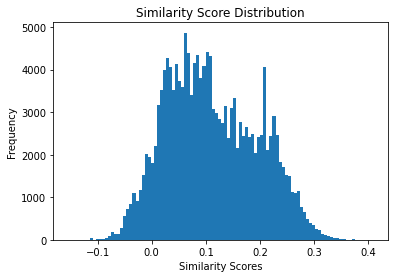

In [16]:
print("QUERY TO MATCH:")
print(query)
embedded_query = embedder([query]).numpy()

similarity_dist = embedded_categories @ embedded_query.T
plt.title('Similarity Score Distribution')
plt.hist(similarity_dist, bins=100)
plt.xlabel('Similarity Scores')
plt.ylabel('Frequency')
plt.show()

Change `threshold` to set the minimum required similarity.

In [17]:
threshold = 0.15

In [18]:
split_dex = np.where(similarity_dist >= threshold)[0]
df_filtered = df_business.iloc[split_dex, :]
print('NUMBER OF MATCHES: ', df_filtered.shape[0])
df_filtered.head()

NUMBER OF MATCHES:  52700


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
5,5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': ""u'none'"", ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
10,10,rYs_1pNB_RMtn5WQh55QDA,Chautauqua General Store,100 Clematis Dr,Boulder,CO,80302,39.998449,-105.281006,3.5,5,1,"{'BikeParking': 'True', 'RestaurantsTakeOut': ...","Food, Shopping, Convenience Stores, Souvenir S...","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ..."
12,12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [19]:
df_filtered.to_csv('data/yelp_academic_dataset_business_filtered.csv')